In [1]:
import pandas as pd
import helper
import evaluator
import optuna
from optuna.samplers import TPESampler
import strategy

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("in_sample.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index("datetime", inplace=True)
df

,tickersymbol,price,quantity,SMA50,SMA20,STD20,UpperBB,LowerBB,Resistance,Support,AvgVolume20
datetime,,,,,,,,,,,
2021-01-15 10:29:00,VN30F2101,1193.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:30:00,VN30F2101,1197.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:31:00,VN30F2101,1194.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:32:00,VN30F2101,1194.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:33:00,VN30F2102,1193.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 14:41:00,VN30F2301,1000.2,0.0,1005.032,1002.635,2.548947,1007.732894,997.537106,1008.9,998.9,1034258.30
2022-12-30 14:42:00,VN30F2301,1000.2,0.0,1004.888,1002.345,2.474815,1007.294630,997.395370,1008.9,998.9,924760.10
2022-12-30 14:43:00,VN30F2301,1000.2,0.0,1004.734,1002.070,2.386387,1006.842774,997.297226,1008.9,998.9,777874.50


In [3]:
# Assume df is already loaded and contains required columns like "Close", "SMA50", "UpperBB", "LowerBB", etc.

initial_balance = 40_000_000
SMA_WINDOW_LENGTH = 50
TAKE_PROFIT_THRES_MEAN_REVERSION = 5
TAKE_PROFIT_THRES_MOMENTUM = 10
CUT_LOSS_THRES_MEAN_REVERSION = 5
CUT_LOSS_THRES_MOMENTUM = 4

results1 = strategy.strategy(
    df,
    SMA_WINDOW_LENGTH,
    TAKE_PROFIT_THRES_MEAN_REVERSION,
    TAKE_PROFIT_THRES_MOMENTUM,
    CUT_LOSS_THRES_MEAN_REVERSION,
    CUT_LOSS_THRES_MOMENTUM,
    initial_balance,
)

# Print results
for key, value in results1.items():
    if key != "PnL Over Time":  # Avoid printing a long list
        print(f"{key}: {value}")


Initial Balance: 40000000
Final Balance: 341921999.99999994
Win Rate: 83.33333333333334
Total Trades: 144
Winning Trades: 120
Losing Trades: 24
Accumulated Return: 7.548049999999998
Sharpe Ratio: 0.013550733578558087
Max Drawdown: -0.1457418178661343


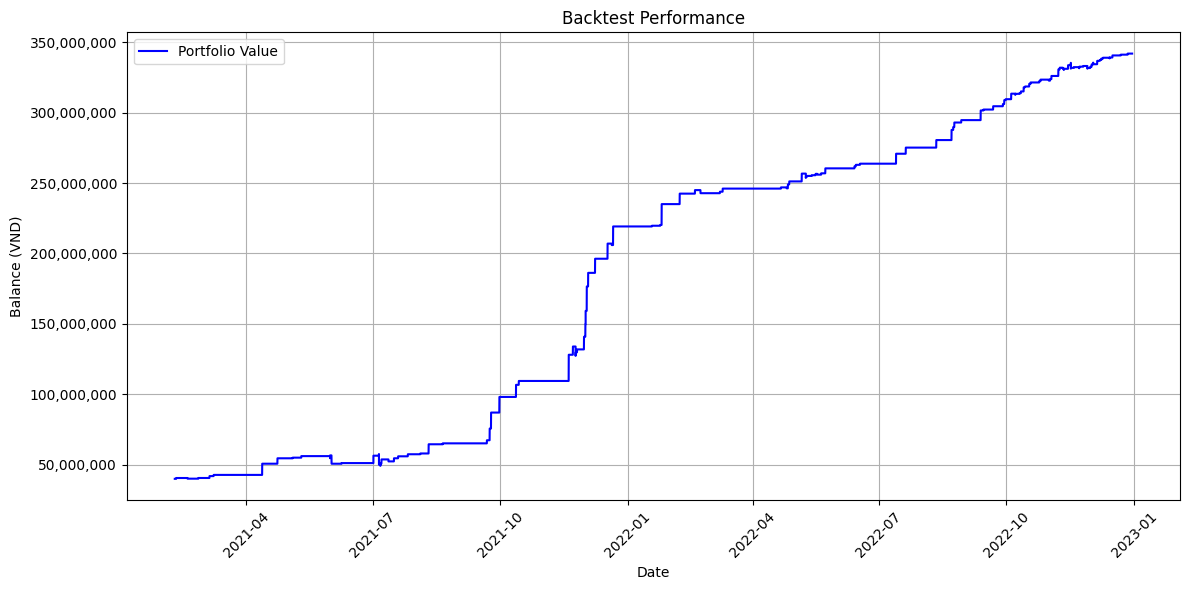

In [4]:
PnL = results1["PnL Over Time"]
date_list = df.index[SMA_WINDOW_LENGTH - 1:]  # Align dates with pnl_list length

helper.plot_performance(PnL, date_list)


# Fine tuning

In [32]:
def optuna_objective(trial):
    sma_window = trial.suggest_int("sma_window", 30, 100)
    tp_mean_rev = trial.suggest_float("tp_mean_rev", 3, 10, step=0.5)
    tp_momentum = trial.suggest_float("tp_momentum", 5, 15, step=0.5)
    sl_mean_rev = trial.suggest_float("sl_mean_rev", 3, 10, step=0.5)
    sl_momentum = trial.suggest_float("sl_momentum", 2, 8, step=0.5)

    result = strategy.strategy(
        df,
        SMA_WINDOW_LENGTH=sma_window,
        TAKE_PROFIT_THRES_MEAN_REVERSION=tp_mean_rev,
        TAKE_PROFIT_THRES_MOMENTUM=tp_momentum,
        CUT_LOSS_THRES_MEAN_REVERSION=sl_mean_rev,
        CUT_LOSS_THRES_MOMENTUM=sl_momentum,
        initial_balance = 40_000_000
    )

    return result["Sharpe Ratio"] 


In [33]:
sampler = TPESampler(seed=710)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(optuna_objective, n_trials=100, show_progress_bar=True)

[I 2025-04-17 17:14:28,531] A new study created in memory with name: no-name-6228e4a2-9a7a-47dc-98bc-e26c3698273d
Best trial: 0. Best value: 0.0138163:   1%|          | 1/100 [00:10<18:03, 10.95s/it]

[I 2025-04-17 17:14:39,474] Trial 0 finished with value: 0.013816343433132757 and parameters: {'sma_window': 90, 'tp_mean_rev': 8.0, 'tp_momentum': 11.5, 'sl_mean_rev': 3.0, 'sl_momentum': 4.0}. Best is trial 0 with value: 0.013816343433132757.


Best trial: 1. Best value: 0.0141681:   2%|▏         | 2/100 [00:20<16:49, 10.30s/it]

[I 2025-04-17 17:14:49,325] Trial 1 finished with value: 0.014168067507621082 and parameters: {'sma_window': 68, 'tp_mean_rev': 7.0, 'tp_momentum': 14.5, 'sl_mean_rev': 10.0, 'sl_momentum': 7.5}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   3%|▎         | 3/100 [00:30<16:21, 10.11s/it]

[I 2025-04-17 17:14:59,217] Trial 2 finished with value: 0.014081385702699461 and parameters: {'sma_window': 71, 'tp_mean_rev': 7.5, 'tp_momentum': 12.0, 'sl_mean_rev': 4.5, 'sl_momentum': 6.0}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   4%|▍         | 4/100 [00:40<16:14, 10.15s/it]

[I 2025-04-17 17:15:09,415] Trial 3 finished with value: 0.013391643981873157 and parameters: {'sma_window': 96, 'tp_mean_rev': 3.5, 'tp_momentum': 5.5, 'sl_mean_rev': 6.5, 'sl_momentum': 6.5}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   5%|▌         | 5/100 [00:50<15:56, 10.07s/it]

[I 2025-04-17 17:15:19,340] Trial 4 finished with value: 0.013356792678852236 and parameters: {'sma_window': 63, 'tp_mean_rev': 6.0, 'tp_momentum': 12.5, 'sl_mean_rev': 3.0, 'sl_momentum': 4.0}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   6%|▌         | 6/100 [01:00<15:48, 10.09s/it]

[I 2025-04-17 17:15:29,473] Trial 5 finished with value: 0.013069450451304393 and parameters: {'sma_window': 100, 'tp_mean_rev': 3.5, 'tp_momentum': 13.0, 'sl_mean_rev': 9.0, 'sl_momentum': 5.0}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   7%|▋         | 7/100 [01:11<15:43, 10.14s/it]

[I 2025-04-17 17:15:39,730] Trial 6 finished with value: 0.01342014974141362 and parameters: {'sma_window': 47, 'tp_mean_rev': 3.5, 'tp_momentum': 9.5, 'sl_mean_rev': 8.0, 'sl_momentum': 7.5}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   8%|▊         | 8/100 [01:21<15:31, 10.12s/it]

[I 2025-04-17 17:15:49,800] Trial 7 finished with value: 0.013954300323911657 and parameters: {'sma_window': 88, 'tp_mean_rev': 7.0, 'tp_momentum': 11.5, 'sl_mean_rev': 6.5, 'sl_momentum': 5.0}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:   9%|▉         | 9/100 [01:31<15:14, 10.05s/it]

[I 2025-04-17 17:15:59,686] Trial 8 finished with value: 0.01401514485778057 and parameters: {'sma_window': 77, 'tp_mean_rev': 7.5, 'tp_momentum': 7.0, 'sl_mean_rev': 3.5, 'sl_momentum': 3.5}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:  10%|█         | 10/100 [01:43<15:55, 10.61s/it]

[I 2025-04-17 17:16:11,572] Trial 9 finished with value: 0.013973432806295033 and parameters: {'sma_window': 39, 'tp_mean_rev': 9.5, 'tp_momentum': 6.5, 'sl_mean_rev': 3.5, 'sl_momentum': 5.0}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 1. Best value: 0.0141681:  11%|█         | 11/100 [01:53<15:50, 10.68s/it]

[I 2025-04-17 17:16:22,392] Trial 10 finished with value: 0.012898547180855556 and parameters: {'sma_window': 56, 'tp_mean_rev': 5.0, 'tp_momentum': 15.0, 'sl_mean_rev': 10.0, 'sl_momentum': 2.0}. Best is trial 1 with value: 0.014168067507621082.


Best trial: 11. Best value: 0.0145492:  12%|█▏        | 12/100 [02:03<15:16, 10.42s/it]

[I 2025-04-17 17:16:32,224] Trial 11 finished with value: 0.014549222209200106 and parameters: {'sma_window': 74, 'tp_mean_rev': 9.5, 'tp_momentum': 15.0, 'sl_mean_rev': 5.0, 'sl_momentum': 8.0}. Best is trial 11 with value: 0.014549222209200106.


Best trial: 12. Best value: 0.0145865:  13%|█▎        | 13/100 [02:14<15:04, 10.40s/it]

[I 2025-04-17 17:16:42,575] Trial 12 finished with value: 0.014586477521058117 and parameters: {'sma_window': 79, 'tp_mean_rev': 10.0, 'tp_momentum': 15.0, 'sl_mean_rev': 5.0, 'sl_momentum': 8.0}. Best is trial 12 with value: 0.014586477521058117.


Best trial: 13. Best value: 0.0145865:  14%|█▍        | 14/100 [02:24<14:54, 10.41s/it]

[I 2025-04-17 17:16:52,995] Trial 13 finished with value: 0.014586538630658914 and parameters: {'sma_window': 80, 'tp_mean_rev': 10.0, 'tp_momentum': 14.0, 'sl_mean_rev': 5.0, 'sl_momentum': 8.0}. Best is trial 13 with value: 0.014586538630658914.


Best trial: 13. Best value: 0.0145865:  15%|█▌        | 15/100 [02:34<14:41, 10.38s/it]

[I 2025-04-17 17:17:03,304] Trial 14 finished with value: 0.014394985942796867 and parameters: {'sma_window': 81, 'tp_mean_rev': 10.0, 'tp_momentum': 9.0, 'sl_mean_rev': 5.5, 'sl_momentum': 6.5}. Best is trial 13 with value: 0.014586538630658914.


Best trial: 13. Best value: 0.0145865:  16%|█▌        | 16/100 [02:45<14:45, 10.54s/it]

[I 2025-04-17 17:17:14,227] Trial 15 finished with value: 0.014255602962049673 and parameters: {'sma_window': 84, 'tp_mean_rev': 8.5, 'tp_momentum': 13.5, 'sl_mean_rev': 5.5, 'sl_momentum': 8.0}. Best is trial 13 with value: 0.014586538630658914.


Best trial: 16. Best value: 0.0146581:  17%|█▋        | 17/100 [02:56<14:42, 10.63s/it]

[I 2025-04-17 17:17:25,062] Trial 16 finished with value: 0.014658143089368126 and parameters: {'sma_window': 59, 'tp_mean_rev': 9.0, 'tp_momentum': 10.5, 'sl_mean_rev': 7.5, 'sl_momentum': 7.0}. Best is trial 16 with value: 0.014658143089368126.


Best trial: 16. Best value: 0.0146581:  18%|█▊        | 18/100 [03:06<14:18, 10.47s/it]

[I 2025-04-17 17:17:35,146] Trial 17 finished with value: 0.014658020292316616 and parameters: {'sma_window': 57, 'tp_mean_rev': 9.0, 'tp_momentum': 10.5, 'sl_mean_rev': 7.5, 'sl_momentum': 7.0}. Best is trial 16 with value: 0.014658143089368126.


Best trial: 16. Best value: 0.0146581:  19%|█▉        | 19/100 [03:16<13:55, 10.31s/it]

[I 2025-04-17 17:17:45,094] Trial 18 finished with value: 0.014284414944875081 and parameters: {'sma_window': 55, 'tp_mean_rev': 8.5, 'tp_momentum': 10.5, 'sl_mean_rev': 8.0, 'sl_momentum': 6.0}. Best is trial 16 with value: 0.014658143089368126.


Best trial: 16. Best value: 0.0146581:  20%|██        | 20/100 [03:27<13:52, 10.41s/it]

[I 2025-04-17 17:17:55,733] Trial 19 finished with value: 0.013937041998529503 and parameters: {'sma_window': 39, 'tp_mean_rev': 5.5, 'tp_momentum': 8.5, 'sl_mean_rev': 8.0, 'sl_momentum': 7.0}. Best is trial 16 with value: 0.014658143089368126.


Best trial: 16. Best value: 0.0146581:  21%|██        | 21/100 [03:38<14:03, 10.68s/it]

[I 2025-04-17 17:18:07,055] Trial 20 finished with value: 0.014422623442481743 and parameters: {'sma_window': 30, 'tp_mean_rev': 9.0, 'tp_momentum': 10.5, 'sl_mean_rev': 7.0, 'sl_momentum': 6.0}. Best is trial 16 with value: 0.014658143089368126.


Best trial: 16. Best value: 0.0146581:  22%|██▏       | 22/100 [03:49<14:10, 10.91s/it]

[I 2025-04-17 17:18:18,492] Trial 21 finished with value: 0.014382034191382448 and parameters: {'sma_window': 59, 'tp_mean_rev': 9.0, 'tp_momentum': 8.0, 'sl_mean_rev': 7.0, 'sl_momentum': 7.0}. Best is trial 16 with value: 0.014658143089368126.


Best trial: 22. Best value: 0.0148246:  23%|██▎       | 23/100 [04:00<14:02, 10.94s/it]

[I 2025-04-17 17:18:29,507] Trial 22 finished with value: 0.014824572187151172 and parameters: {'sma_window': 51, 'tp_mean_rev': 10.0, 'tp_momentum': 10.5, 'sl_mean_rev': 9.0, 'sl_momentum': 7.0}. Best is trial 22 with value: 0.014824572187151172.


Best trial: 22. Best value: 0.0148246:  24%|██▍       | 24/100 [04:10<13:29, 10.66s/it]

[I 2025-04-17 17:18:39,499] Trial 23 finished with value: 0.014657590526938578 and parameters: {'sma_window': 50, 'tp_mean_rev': 9.0, 'tp_momentum': 10.5, 'sl_mean_rev': 9.0, 'sl_momentum': 7.0}. Best is trial 22 with value: 0.014824572187151172.


Best trial: 22. Best value: 0.0148246:  25%|██▌       | 25/100 [04:21<13:26, 10.75s/it]

[I 2025-04-17 17:18:50,483] Trial 24 finished with value: 0.01413955504682434 and parameters: {'sma_window': 49, 'tp_mean_rev': 8.0, 'tp_momentum': 10.0, 'sl_mean_rev': 9.0, 'sl_momentum': 5.5}. Best is trial 22 with value: 0.014824572187151172.


Best trial: 22. Best value: 0.0148246:  26%|██▌       | 26/100 [04:32<13:06, 10.63s/it]

[I 2025-04-17 17:19:00,832] Trial 25 finished with value: 0.014806573198388994 and parameters: {'sma_window': 62, 'tp_mean_rev': 9.5, 'tp_momentum': 11.5, 'sl_mean_rev': 7.5, 'sl_momentum': 6.5}. Best is trial 22 with value: 0.014824572187151172.


Best trial: 22. Best value: 0.0148246:  27%|██▋       | 27/100 [04:42<12:45, 10.49s/it]

[I 2025-04-17 17:19:10,994] Trial 26 finished with value: 0.014806697245674998 and parameters: {'sma_window': 64, 'tp_mean_rev': 9.5, 'tp_momentum': 11.5, 'sl_mean_rev': 8.5, 'sl_momentum': 6.5}. Best is trial 22 with value: 0.014824572187151172.


Best trial: 22. Best value: 0.0148246:  28%|██▊       | 28/100 [04:52<12:22, 10.31s/it]

[I 2025-04-17 17:19:20,870] Trial 27 finished with value: 0.013132956793558212 and parameters: {'sma_window': 63, 'tp_mean_rev': 4.5, 'tp_momentum': 11.5, 'sl_mean_rev': 8.5, 'sl_momentum': 5.5}. Best is trial 22 with value: 0.014824572187151172.


Best trial: 28. Best value: 0.0148373:  29%|██▉       | 29/100 [05:02<12:07, 10.24s/it]

[I 2025-04-17 17:19:30,965] Trial 28 finished with value: 0.014837330629338247 and parameters: {'sma_window': 43, 'tp_mean_rev': 10.0, 'tp_momentum': 13.0, 'sl_mean_rev': 9.5, 'sl_momentum': 6.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  30%|███       | 30/100 [05:12<11:48, 10.12s/it]

[I 2025-04-17 17:19:40,799] Trial 29 finished with value: 0.014139140516534554 and parameters: {'sma_window': 42, 'tp_mean_rev': 8.0, 'tp_momentum': 12.5, 'sl_mean_rev': 9.5, 'sl_momentum': 5.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  31%|███       | 31/100 [05:22<11:37, 10.12s/it]

[I 2025-04-17 17:19:50,903] Trial 30 finished with value: 0.014653427853994308 and parameters: {'sma_window': 33, 'tp_mean_rev': 10.0, 'tp_momentum': 13.5, 'sl_mean_rev': 9.5, 'sl_momentum': 4.0}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  32%|███▏      | 32/100 [05:32<11:26, 10.09s/it]

[I 2025-04-17 17:20:00,936] Trial 31 finished with value: 0.014805518922320758 and parameters: {'sma_window': 45, 'tp_mean_rev': 9.5, 'tp_momentum': 11.5, 'sl_mean_rev': 8.5, 'sl_momentum': 6.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  33%|███▎      | 33/100 [05:44<12:05, 10.84s/it]

[I 2025-04-17 17:20:13,507] Trial 32 finished with value: 0.014771430919141224 and parameters: {'sma_window': 68, 'tp_mean_rev': 9.5, 'tp_momentum': 12.0, 'sl_mean_rev': 9.5, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  34%|███▍      | 34/100 [05:55<11:54, 10.82s/it]

[I 2025-04-17 17:20:24,288] Trial 33 finished with value: 0.01453219937909991 and parameters: {'sma_window': 52, 'tp_mean_rev': 8.5, 'tp_momentum': 12.5, 'sl_mean_rev': 8.5, 'sl_momentum': 6.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  35%|███▌      | 35/100 [06:05<11:25, 10.54s/it]

[I 2025-04-17 17:20:34,177] Trial 34 finished with value: 0.014591154766338854 and parameters: {'sma_window': 68, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 9.5, 'sl_momentum': 6.0}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  36%|███▌      | 36/100 [06:15<11:07, 10.43s/it]

[I 2025-04-17 17:20:44,341] Trial 35 finished with value: 0.014117879042659839 and parameters: {'sma_window': 65, 'tp_mean_rev': 6.5, 'tp_momentum': 9.5, 'sl_mean_rev': 10.0, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  37%|███▋      | 37/100 [06:25<10:45, 10.24s/it]

[I 2025-04-17 17:20:54,151] Trial 36 finished with value: 0.014551893498110651 and parameters: {'sma_window': 43, 'tp_mean_rev': 9.5, 'tp_momentum': 13.0, 'sl_mean_rev': 7.5, 'sl_momentum': 4.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  38%|███▊      | 38/100 [06:35<10:35, 10.25s/it]

[I 2025-04-17 17:21:04,430] Trial 37 finished with value: 0.014092300508978023 and parameters: {'sma_window': 53, 'tp_mean_rev': 7.5, 'tp_momentum': 12.0, 'sl_mean_rev': 9.0, 'sl_momentum': 6.0}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  39%|███▉      | 39/100 [06:46<10:30, 10.33s/it]

[I 2025-04-17 17:21:14,936] Trial 38 finished with value: 0.014533416891251318 and parameters: {'sma_window': 72, 'tp_mean_rev': 8.5, 'tp_momentum': 14.0, 'sl_mean_rev': 8.5, 'sl_momentum': 6.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  40%|████      | 40/100 [06:56<10:12, 10.20s/it]

[I 2025-04-17 17:21:24,850] Trial 39 finished with value: 0.014825068952689872 and parameters: {'sma_window': 59, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 7.0, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  41%|████      | 41/100 [07:06<10:00, 10.18s/it]

[I 2025-04-17 17:21:34,976] Trial 40 finished with value: 0.01305760875847506 and parameters: {'sma_window': 36, 'tp_mean_rev': 3.0, 'tp_momentum': 13.0, 'sl_mean_rev': 6.0, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  42%|████▏     | 42/100 [07:16<09:43, 10.07s/it]

[I 2025-04-17 17:21:44,771] Trial 41 finished with value: 0.014825193151877745 and parameters: {'sma_window': 61, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 7.0, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  43%|████▎     | 43/100 [07:26<09:32, 10.05s/it]

[I 2025-04-17 17:21:54,775] Trial 42 finished with value: 0.014792381184207897 and parameters: {'sma_window': 48, 'tp_mean_rev': 10.0, 'tp_momentum': 9.5, 'sl_mean_rev': 7.0, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  44%|████▍     | 44/100 [07:36<09:33, 10.25s/it]

[I 2025-04-17 17:22:05,486] Trial 43 finished with value: 0.014092312470245349 and parameters: {'sma_window': 62, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 6.0, 'sl_momentum': 2.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  45%|████▌     | 45/100 [07:49<09:57, 10.86s/it]

[I 2025-04-17 17:22:17,792] Trial 44 finished with value: 0.014806015024181274 and parameters: {'sma_window': 53, 'tp_mean_rev': 9.5, 'tp_momentum': 11.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.0}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  46%|████▌     | 46/100 [07:59<09:35, 10.65s/it]

[I 2025-04-17 17:22:27,937] Trial 45 finished with value: 0.014691397267696514 and parameters: {'sma_window': 59, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 8.0, 'sl_momentum': 8.0}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  47%|████▋     | 47/100 [08:09<09:12, 10.42s/it]

[I 2025-04-17 17:22:37,833] Trial 46 finished with value: 0.013693537629942267 and parameters: {'sma_window': 69, 'tp_mean_rev': 9.5, 'tp_momentum': 5.0, 'sl_mean_rev': 10.0, 'sl_momentum': 7.5}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 28. Best value: 0.0148373:  48%|████▊     | 48/100 [08:20<09:08, 10.55s/it]

[I 2025-04-17 17:22:48,685] Trial 47 finished with value: 0.014657344963694006 and parameters: {'sma_window': 46, 'tp_mean_rev': 9.0, 'tp_momentum': 12.5, 'sl_mean_rev': 9.0, 'sl_momentum': 7.0}. Best is trial 28 with value: 0.014837330629338247.


Best trial: 48. Best value: 0.0148386:  49%|████▉     | 49/100 [08:29<08:46, 10.32s/it]

[I 2025-04-17 17:22:58,471] Trial 48 finished with value: 0.014838635780793847 and parameters: {'sma_window': 64, 'tp_mean_rev': 10.0, 'tp_momentum': 12.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  50%|█████     | 50/100 [08:40<08:34, 10.30s/it]

[I 2025-04-17 17:23:08,712] Trial 49 finished with value: 0.014656005913513005 and parameters: {'sma_window': 75, 'tp_mean_rev': 10.0, 'tp_momentum': 12.0, 'sl_mean_rev': 4.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  51%|█████     | 51/100 [08:50<08:21, 10.24s/it]

[I 2025-04-17 17:23:18,831] Trial 50 finished with value: 0.01428662921373089 and parameters: {'sma_window': 92, 'tp_mean_rev': 8.5, 'tp_momentum': 14.0, 'sl_mean_rev': 6.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  52%|█████▏    | 52/100 [09:00<08:14, 10.30s/it]

[I 2025-04-17 17:23:29,252] Trial 51 finished with value: 0.014806759270487168 and parameters: {'sma_window': 65, 'tp_mean_rev': 9.5, 'tp_momentum': 11.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  53%|█████▎    | 53/100 [09:10<08:00, 10.22s/it]

[I 2025-04-17 17:23:39,288] Trial 52 finished with value: 0.0148382006920406 and parameters: {'sma_window': 57, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 6.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  54%|█████▍    | 54/100 [09:21<07:53, 10.29s/it]

[I 2025-04-17 17:23:49,742] Trial 53 finished with value: 0.01482488265976066 and parameters: {'sma_window': 56, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  55%|█████▌    | 55/100 [09:31<07:37, 10.18s/it]

[I 2025-04-17 17:23:59,654] Trial 54 finished with value: 0.0146580816904566 and parameters: {'sma_window': 58, 'tp_mean_rev': 9.0, 'tp_momentum': 9.0, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  56%|█████▌    | 56/100 [09:42<07:49, 10.67s/it]

[I 2025-04-17 17:24:11,468] Trial 55 finished with value: 0.014565632520310038 and parameters: {'sma_window': 56, 'tp_mean_rev': 10.0, 'tp_momentum': 12.0, 'sl_mean_rev': 5.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  57%|█████▋    | 57/100 [09:53<07:40, 10.71s/it]

[I 2025-04-17 17:24:22,278] Trial 56 finished with value: 0.01483844930949884 and parameters: {'sma_window': 61, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 6.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  58%|█████▊    | 58/100 [10:04<07:24, 10.58s/it]

[I 2025-04-17 17:24:32,548] Trial 57 finished with value: 0.013427089644417101 and parameters: {'sma_window': 60, 'tp_mean_rev': 4.5, 'tp_momentum': 7.5, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  59%|█████▉    | 59/100 [10:14<07:09, 10.47s/it]

[I 2025-04-17 17:24:42,751] Trial 58 finished with value: 0.01442485867617648 and parameters: {'sma_window': 67, 'tp_mean_rev': 9.5, 'tp_momentum': 9.0, 'sl_mean_rev': 6.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  60%|██████    | 60/100 [10:24<06:52, 10.30s/it]

[I 2025-04-17 17:24:52,671] Trial 59 finished with value: 0.014479855961623966 and parameters: {'sma_window': 72, 'tp_mean_rev': 9.0, 'tp_momentum': 13.5, 'sl_mean_rev': 5.5, 'sl_momentum': 3.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  61%|██████    | 61/100 [10:34<06:40, 10.28s/it]

[I 2025-04-17 17:25:02,896] Trial 60 finished with value: 0.013705598356001589 and parameters: {'sma_window': 61, 'tp_mean_rev': 6.0, 'tp_momentum': 11.0, 'sl_mean_rev': 4.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  62%|██████▏   | 62/100 [10:44<06:25, 10.15s/it]

[I 2025-04-17 17:25:12,734] Trial 61 finished with value: 0.01482488265976066 and parameters: {'sma_window': 56, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  63%|██████▎   | 63/100 [10:54<06:17, 10.21s/it]

[I 2025-04-17 17:25:23,081] Trial 62 finished with value: 0.014802685354517097 and parameters: {'sma_window': 54, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  64%|██████▍   | 64/100 [11:04<06:06, 10.19s/it]

[I 2025-04-17 17:25:33,236] Trial 63 finished with value: 0.014806821296078803 and parameters: {'sma_window': 66, 'tp_mean_rev': 10.0, 'tp_momentum': 9.5, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  65%|██████▌   | 65/100 [11:14<05:55, 10.16s/it]

[I 2025-04-17 17:25:43,328] Trial 64 finished with value: 0.014519192249254268 and parameters: {'sma_window': 60, 'tp_mean_rev': 9.5, 'tp_momentum': 8.5, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  66%|██████▌   | 66/100 [11:24<05:42, 10.07s/it]

[I 2025-04-17 17:25:53,193] Trial 65 finished with value: 0.014192934363379837 and parameters: {'sma_window': 63, 'tp_mean_rev': 7.0, 'tp_momentum': 13.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  67%|██████▋   | 67/100 [11:35<05:35, 10.15s/it]

[I 2025-04-17 17:26:03,528] Trial 66 finished with value: 0.014559679527993601 and parameters: {'sma_window': 70, 'tp_mean_rev': 9.5, 'tp_momentum': 10.5, 'sl_mean_rev': 6.0, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  68%|██████▊   | 68/100 [11:46<05:42, 10.69s/it]

[I 2025-04-17 17:26:15,485] Trial 67 finished with value: 0.01464181379260308 and parameters: {'sma_window': 57, 'tp_mean_rev': 9.0, 'tp_momentum': 11.5, 'sl_mean_rev': 7.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  69%|██████▉   | 69/100 [11:56<05:23, 10.44s/it]

[I 2025-04-17 17:26:25,336] Trial 68 finished with value: 0.01482482056367822 and parameters: {'sma_window': 55, 'tp_mean_rev': 10.0, 'tp_momentum': 12.5, 'sl_mean_rev': 7.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  70%|███████   | 70/100 [12:08<05:21, 10.72s/it]

[I 2025-04-17 17:26:36,719] Trial 69 finished with value: 0.014770255364140929 and parameters: {'sma_window': 49, 'tp_mean_rev': 9.5, 'tp_momentum': 10.0, 'sl_mean_rev': 7.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  71%|███████   | 71/100 [12:18<05:11, 10.74s/it]

[I 2025-04-17 17:26:47,512] Trial 70 finished with value: 0.014824572187151172 and parameters: {'sma_window': 51, 'tp_mean_rev': 10.0, 'tp_momentum': 11.5, 'sl_mean_rev': 8.0, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  72%|███████▏  | 72/100 [12:29<04:56, 10.59s/it]

[I 2025-04-17 17:26:57,752] Trial 71 finished with value: 0.01482488265976066 and parameters: {'sma_window': 56, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  73%|███████▎  | 73/100 [12:39<04:44, 10.53s/it]

[I 2025-04-17 17:27:08,142] Trial 72 finished with value: 0.014806325113169873 and parameters: {'sma_window': 58, 'tp_mean_rev': 10.0, 'tp_momentum': 9.5, 'sl_mean_rev': 6.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  74%|███████▍  | 74/100 [12:50<04:34, 10.55s/it]

[I 2025-04-17 17:27:18,736] Trial 73 finished with value: 0.014793186679606114 and parameters: {'sma_window': 61, 'tp_mean_rev': 9.5, 'tp_momentum': 10.5, 'sl_mean_rev': 7.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  75%|███████▌  | 75/100 [13:00<04:22, 10.49s/it]

[I 2025-04-17 17:27:29,081] Trial 74 finished with value: 0.014251691920938179 and parameters: {'sma_window': 39, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 3.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  76%|███████▌  | 76/100 [13:10<04:10, 10.43s/it]

[I 2025-04-17 17:27:39,376] Trial 75 finished with value: 0.014529133126680312 and parameters: {'sma_window': 63, 'tp_mean_rev': 9.5, 'tp_momentum': 12.0, 'sl_mean_rev': 5.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  77%|███████▋  | 77/100 [13:21<04:02, 10.56s/it]

[I 2025-04-17 17:27:50,243] Trial 76 finished with value: 0.014284355114059049 and parameters: {'sma_window': 54, 'tp_mean_rev': 9.0, 'tp_momentum': 8.5, 'sl_mean_rev': 6.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  78%|███████▊  | 78/100 [13:31<03:50, 10.45s/it]

[I 2025-04-17 17:28:00,448] Trial 77 finished with value: 0.014806759270487168 and parameters: {'sma_window': 65, 'tp_mean_rev': 10.0, 'tp_momentum': 9.5, 'sl_mean_rev': 6.5, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  79%|███████▉  | 79/100 [13:44<03:52, 11.07s/it]

[I 2025-04-17 17:28:12,945] Trial 78 finished with value: 0.014551954444381288 and parameters: {'sma_window': 44, 'tp_mean_rev': 9.5, 'tp_momentum': 10.5, 'sl_mean_rev': 7.5, 'sl_momentum': 4.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  80%|████████  | 80/100 [13:55<03:40, 11.05s/it]

[I 2025-04-17 17:28:23,954] Trial 79 finished with value: 0.014531895048869214 and parameters: {'sma_window': 47, 'tp_mean_rev': 8.5, 'tp_momentum': 11.5, 'sl_mean_rev': 7.0, 'sl_momentum': 6.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  81%|████████  | 81/100 [14:05<03:26, 10.85s/it]

[I 2025-04-17 17:28:34,348] Trial 80 finished with value: 0.014690904983234743 and parameters: {'sma_window': 51, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 8.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  82%|████████▏ | 82/100 [14:16<03:13, 10.73s/it]

[I 2025-04-17 17:28:44,789] Trial 81 finished with value: 0.01482488265976066 and parameters: {'sma_window': 56, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  83%|████████▎ | 83/100 [14:27<03:03, 10.79s/it]

[I 2025-04-17 17:28:55,718] Trial 82 finished with value: 0.014825006854266465 and parameters: {'sma_window': 58, 'tp_mean_rev': 10.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  84%|████████▍ | 84/100 [14:37<02:50, 10.68s/it]

[I 2025-04-17 17:29:06,142] Trial 83 finished with value: 0.014671592219437639 and parameters: {'sma_window': 58, 'tp_mean_rev': 9.5, 'tp_momentum': 9.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  85%|████████▌ | 85/100 [14:48<02:39, 10.62s/it]

[I 2025-04-17 17:29:16,633] Trial 84 finished with value: 0.014803119390519147 and parameters: {'sma_window': 61, 'tp_mean_rev': 10.0, 'tp_momentum': 10.5, 'sl_mean_rev': 7.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  86%|████████▌ | 86/100 [14:58<02:27, 10.53s/it]

[I 2025-04-17 17:29:26,948] Trial 85 finished with value: 0.014657774707471788 and parameters: {'sma_window': 53, 'tp_mean_rev': 9.0, 'tp_momentum': 10.0, 'sl_mean_rev': 7.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  87%|████████▋ | 87/100 [15:08<02:16, 10.48s/it]

[I 2025-04-17 17:29:37,321] Trial 86 finished with value: 0.013915434321010936 and parameters: {'sma_window': 66, 'tp_mean_rev': 9.5, 'tp_momentum': 6.5, 'sl_mean_rev': 6.0, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  88%|████████▊ | 88/100 [15:19<02:04, 10.41s/it]

[I 2025-04-17 17:29:47,569] Trial 87 finished with value: 0.014838324999207614 and parameters: {'sma_window': 59, 'tp_mean_rev': 10.0, 'tp_momentum': 10.5, 'sl_mean_rev': 6.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  89%|████████▉ | 89/100 [15:29<01:55, 10.53s/it]

[I 2025-04-17 17:29:58,362] Trial 88 finished with value: 0.014836895655377925 and parameters: {'sma_window': 36, 'tp_mean_rev': 10.0, 'tp_momentum': 10.5, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  90%|█████████ | 90/100 [15:41<01:50, 11.02s/it]

[I 2025-04-17 17:30:10,521] Trial 89 finished with value: 0.014805270890090393 and parameters: {'sma_window': 41, 'tp_mean_rev': 9.5, 'tp_momentum': 11.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  91%|█████████ | 91/100 [15:53<01:40, 11.12s/it]

[I 2025-04-17 17:30:21,879] Trial 90 finished with value: 0.014583728383700336 and parameters: {'sma_window': 34, 'tp_mean_rev': 10.0, 'tp_momentum': 10.5, 'sl_mean_rev': 5.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  92%|█████████▏| 92/100 [16:03<01:26, 10.86s/it]

[I 2025-04-17 17:30:32,128] Trial 91 finished with value: 0.01458889373405098 and parameters: {'sma_window': 31, 'tp_mean_rev': 10.0, 'tp_momentum': 10.5, 'sl_mean_rev': 6.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  93%|█████████▎| 93/100 [16:14<01:16, 10.89s/it]

[I 2025-04-17 17:30:43,092] Trial 92 finished with value: 0.014806387133305584 and parameters: {'sma_window': 59, 'tp_mean_rev': 9.5, 'tp_momentum': 11.5, 'sl_mean_rev': 6.5, 'sl_momentum': 8.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  94%|█████████▍| 94/100 [16:24<01:03, 10.65s/it]

[I 2025-04-17 17:30:53,168] Trial 93 finished with value: 0.014836957792172954 and parameters: {'sma_window': 37, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  95%|█████████▌| 95/100 [16:35<00:53, 10.73s/it]

[I 2025-04-17 17:31:04,092] Trial 94 finished with value: 0.014589199217532683 and parameters: {'sma_window': 36, 'tp_mean_rev': 10.0, 'tp_momentum': 12.0, 'sl_mean_rev': 6.0, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  96%|█████████▌| 96/100 [16:46<00:42, 10.64s/it]

[I 2025-04-17 17:31:14,537] Trial 95 finished with value: 0.014805022870325228 and parameters: {'sma_window': 37, 'tp_mean_rev': 9.5, 'tp_momentum': 11.0, 'sl_mean_rev': 6.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  97%|█████████▋| 97/100 [16:56<00:31, 10.59s/it]

[I 2025-04-17 17:31:24,986] Trial 96 finished with value: 0.014564656456898127 and parameters: {'sma_window': 40, 'tp_mean_rev': 10.0, 'tp_momentum': 11.5, 'sl_mean_rev': 5.5, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  98%|█████████▊| 98/100 [17:06<00:20, 10.48s/it]

[I 2025-04-17 17:31:35,232] Trial 97 finished with value: 0.014670117518405197 and parameters: {'sma_window': 34, 'tp_mean_rev': 9.0, 'tp_momentum': 12.5, 'sl_mean_rev': 6.5, 'sl_momentum': 7.0}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386:  99%|█████████▉| 99/100 [17:17<00:10, 10.48s/it]

[I 2025-04-17 17:31:45,708] Trial 98 finished with value: 0.014589260316531858 and parameters: {'sma_window': 37, 'tp_mean_rev': 10.0, 'tp_momentum': 11.0, 'sl_mean_rev': 6.0, 'sl_momentum': 7.5}. Best is trial 48 with value: 0.014838635780793847.


Best trial: 48. Best value: 0.0148386: 100%|██████████| 100/100 [17:27<00:00, 10.47s/it]

[I 2025-04-17 17:31:55,909] Trial 99 finished with value: 0.014393975310186788 and parameters: {'sma_window': 31, 'tp_mean_rev': 8.0, 'tp_momentum': 10.5, 'sl_mean_rev': 6.5, 'sl_momentum': 6.5}. Best is trial 48 with value: 0.014838635780793847.


In [34]:
# Print the best parameters set along with the best Sharpe ratio
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 0.014838635780793847
  Params: 
    sma_window: 64
    tp_mean_rev: 10.0
    tp_momentum: 12.0
    sl_mean_rev: 6.5
    sl_momentum: 7.5


# Optimized parameters

In [5]:


initial_balance = 40_000_000
SMA_WINDOW_LENGTH = 64
TAKE_PROFIT_THRES_MEAN_REVERSION = 10
TAKE_PROFIT_THRES_MOMENTUM = 12
CUT_LOSS_THRES_MEAN_REVERSION = 6.5
CUT_LOSS_THRES_MOMENTUM = 7.5

results2 = strategy.strategy(
    df,
    SMA_WINDOW_LENGTH,
    TAKE_PROFIT_THRES_MEAN_REVERSION,
    TAKE_PROFIT_THRES_MOMENTUM,
    CUT_LOSS_THRES_MEAN_REVERSION,
    CUT_LOSS_THRES_MOMENTUM,
    initial_balance,
)

# Print results
for key, value in results2.items():
    if key != "PnL Over Time":  # Avoid printing a long list
        print(f"{key}: {value}")


Initial Balance: 40000000
Final Balance: 382343999.99999994
Win Rate: 83.33333333333334
Total Trades: 138
Winning Trades: 115
Losing Trades: 23
Accumulated Return: 8.558599999999998
Sharpe Ratio: 0.014838635780793847
Max Drawdown: -0.13834363411619272


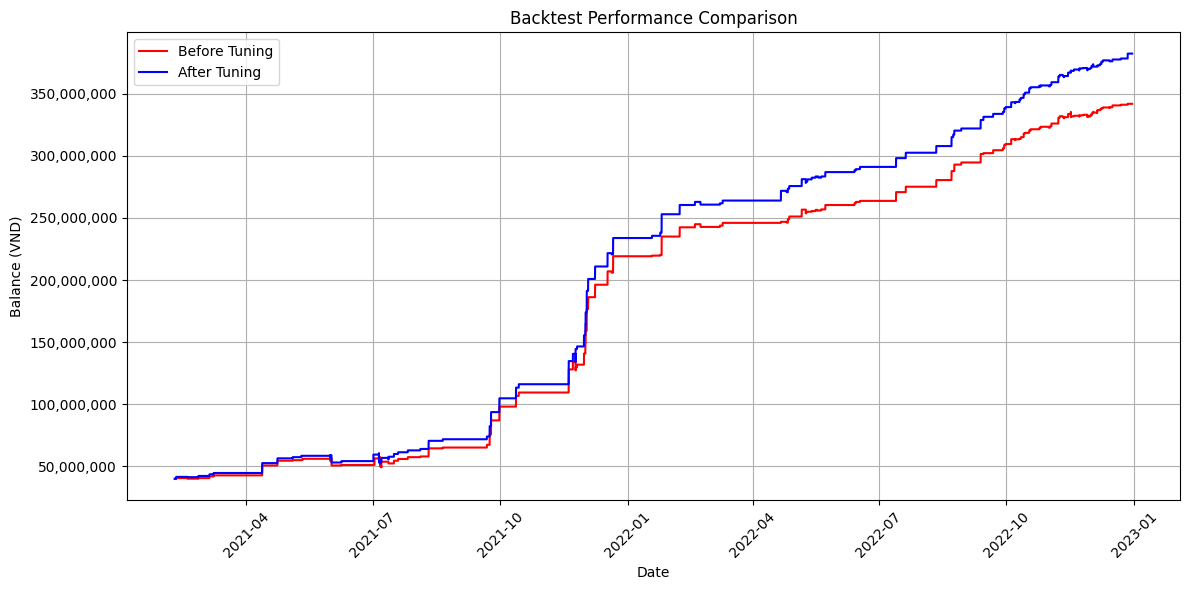

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

PnL_before = results1["PnL Over Time"]
PnL_after = results2["PnL Over Time"]
dates = df.index[SMA_WINDOW_LENGTH - 1:]
labels=("Before Tuning", "After Tuning")

min_len = min(len(PnL_before), len(PnL_after))

PnL_before = PnL_before[:min_len]
PnL_after = PnL_after[:min_len]
dates = dates[:min_len]

plt.figure(figsize=(12, 6))
    
plt.plot(dates, PnL_before, label=labels[0], color="red")
plt.plot(dates, PnL_after, label=labels[1], color="blue")

plt.xlabel("Date")
plt.ylabel("Balance (VND)")
plt.title("Backtest Performance Comparison")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
formatter = FuncFormatter(lambda x, _: f"{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()